In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import matplotlib.cm as cm
import matplotlib as mpl
import pynbody
import math
import numpy as np
import socket
from bulk import *
import copy

# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [7]:
def read_file(simname):
    ### leave this section as is
    data = []
    with open('/home/akinshol/Data/DataFiles_Archive_20191129/'+ simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

        data1 = pd.DataFrame(data)
        data1['sim'] = [simname]*len(data1)
        data1['g-r'] = 1.646*(data1['V_mag'] - data1['R_mag']) - 0.139
        return data1

In [2]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

def plt_halos_full(name,tfile,outfilebase,tfile_base,*halo_nums, width_wide=1500, width_narrow=800, circles_on_dm_only=False):

    #min_mass = 1e9 #Minimum halo mass for analysis in solar masses
    min_nstar =  100 #Minimum number of stars for
    min_vmass = 1e8
    min_noncontamFrac = 0.9 #Mass fraction in low mass DM particles

    if halo_nums:
        halo_nums = halo_nums[0]
        
    s = pynbody.load(tfile)
    s.physical_units()
    h = s.halos()
    h_dummy = s.halos(dummy = True)
    print('Loaded simulation')

    fig1, ax1 = plt.subplots(2,3, figsize=(9.5,7),dpi=500)
    
    labels = []

    i = 0
    #Loop through all the halos, breaking when the virial mass is below min_mass
    h1x = h_dummy[1].properties['Xc']
    h1y = h_dummy[1].properties['Yc']
    h1z = h_dummy[1].properties['Zc']
    
    width = width_wide
    smin, smax = -width//2, width//2
    print('Centering halo 1')
    pynbody.analysis.halo.center(h[1])
    
    # h148
#     dm_vmin, dm_vmax = 1e2, 1e8
#     gas_vmin, gas_vmax = 1e2, 1e8
#     star_vmin, star_vmax = 1e2, 1e9
    

    # h329 
    dm_vmin, dm_vmax = 8e1, 8e7
    gas_vmin, gas_vmax = 1e1, 3e7
    star_vmin, star_vmax = 5e0, 1e8
    
    
    print('Making DM image...')
    im = pynbody.plot.sph.image(s.dm[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='Greys_r', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[0,0].imshow(im, norm=colors.LogNorm(), cmap='Greys_r', extent = [smin,smax,smin,smax], vmin=dm_vmin, vmax=dm_vmax,origin='lower')
    
    print('Making gas image...')
    im = pynbody.plot.sph.image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='viridis', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[0,1].imshow(im, norm=colors.LogNorm(), cmap='viridis', extent = [smin,smax,smin,smax], vmin=gas_vmin, vmax=gas_vmax,origin='lower')

    
    print('Making star image...')
    im = pynbody.plot.sph.image(s.s[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='cubehelix', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    my_cmap = copy.copy(mpl.cm.get_cmap('cubehelix')) # copy the default cmap
    my_cmap.set_bad(my_cmap(0))
    
    im = ax1[0,2].imshow(im, norm=colors.LogNorm(), cmap=my_cmap, extent= [smin,smax,smin,smax], vmin=star_vmin, vmax=star_vmax,origin='lower')
    
    
    width = width_narrow
    smin, smax = -width//2, width//2
    print('Centering halo 1')
    pynbody.analysis.halo.center(h[1])
    
    print('Making zoomed DM image...')
    im = pynbody.plot.sph.image(s.dm[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='Greys_r', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[1,0].imshow(im, norm=colors.LogNorm(), cmap='Greys_r', extent = [smin,smax,smin,smax], vmin=dm_vmin, vmax=dm_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[1,0])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Dark Matter Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    print('Making zoomed gas image...')
    im = pynbody.plot.sph.image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='viridis', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[1,1].imshow(im, norm=colors.LogNorm(), cmap='viridis', extent = [smin,smax,smin,smax], vmin=gas_vmin, vmax=gas_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[1,1])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Gas Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    print('Making zoomed star image...')
    im = pynbody.plot.sph.image(s.s[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='cubehelix', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    my_cmap = copy.copy(mpl.cm.get_cmap('cubehelix')) # copy the default cmap
    my_cmap.set_bad(my_cmap(0))
    
    im = ax1[1,2].imshow(im, norm=colors.LogNorm(), cmap=my_cmap, extent= [smin,smax,smin,smax], vmin=star_vmin, vmax=star_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[1,2])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Stellar Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    data = read_file(name) 
    
    h1rvir = 0
    print('Adding circles...')
    for ihalo in range(1,len(h)): #len(h)-1):
        
        if not halo_nums:
            nstar = h_dummy[ihalo].properties['n_star']
            fMhires = h_dummy[ihalo].properties['fMhires']
            mass = h_dummy[ihalo].properties['mass']
            valid_halo = (nstar >= min_nstar) and (fMhires >= min_noncontamFrac) and (mass >= min_vmass)
        else:
            valid_halo = str(h_dummy[ihalo].properties['halo_id']) in halo_nums

            
        if valid_halo:
            labels.append(str(ihalo))
            print(h_dummy[ihalo].properties['halo_id'])
            
            
            x = (h_dummy[ihalo].properties['Xc']-h1x)/0.6776942783267969
            y = (h_dummy[ihalo].properties['Yc']-h1y)/0.6776942783267969
            z = (h_dummy[ihalo].properties['Zc']-h1z)/0.6776942783267969
            rvir = h_dummy[ihalo].properties['Rvir']/0.6776942783267969
            
            
            if float(data[data.haloid==ihalo].sSFR.tolist()[0]) < 1e-11:
                colorVal = '#ff837a'
            else:
                colorVal = '#79aefc'
            
            if ihalo==1:
                h1rvir = rvir
                style = '-'
                colorVal = 'w'
                width=1.5
            else:
                width=1.
                dist = math.sqrt(x*x + y*y + z*z)
                if dist < h1rvir:
                    style = '--'
                else:
                    style = '-'
                    
            
                

            
            circlexy1 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy2 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy3 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy4 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy5 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy6 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            

            ax1[0,0].add_artist(circlexy1)
            ax1[1,0].add_artist(circlexy2)
            
            if ihalo==1:
                ax1[0,1].add_artist(circlexy3)
                ax1[1,1].add_artist(circlexy4)
                ax1[0,2].add_artist(circlexy5)
                ax1[1,2].add_artist(circlexy6)
            
            if not circles_on_dm_only:
                ax1[0,1].add_artist(circlexy3)
                ax1[1,1].add_artist(circlexy4)
                ax1[0,2].add_artist(circlexy5)
                ax1[1,2].add_artist(circlexy6)

            fig1.show()
            i += 1
            
            
    #ax1.set_title(tfile_base)
    #ax1.legend(labels,loc = 1)
    
    for j in [0,1]:
        for i in [0,1,2]:
            ax1[j,i].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
            ax1[j,i].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    

    plt.subplots_adjust(wspace=0.05,hspace=0.02)
    fig1.show()
    fig1.savefig(outfilebase + '.halos_xy.png',dpi=300)

    fig1.clear()

In [15]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

def plt_halos(name,tfile,outfilebase,tfile_base,*halo_nums, width=1000, circles_on_dm_only=True):

    #min_mass = 1e9 #Minimum halo mass for analysis in solar masses
    min_nstar =  100 #Minimum number of stars for
    min_vmass = 1e8
    min_noncontamFrac = 0.9 #Mass fraction in low mass DM particles

    if halo_nums:
        halo_nums = halo_nums[0]
        
    s = pynbody.load(tfile)
    s.physical_units()
    h = s.halos()
    h_dummy = s.halos(dummy = True)
    print('Loaded simulation')
    
    
    plt.style.use('dark_background')
    fig1, ax1 = plt.subplots(1,3, figsize=(9.5,3.7),dpi=500)
    
    labels = []

    i = 0

    h1x = h_dummy[1].properties['Xc']
    h1y = h_dummy[1].properties['Yc']
    h1z = h_dummy[1].properties['Zc']
    
#     #h148
    dm_vmin, dm_vmax = 1e2, 9e7
    gas_vmin, gas_vmax = 1e2, 9e7
    star_vmin, star_vmax = 1e2, 1e9

#     # h229
#     dm_vmin, dm_vmax = 1e2, 9e7
#     gas_vmin, gas_vmax = 1e2, 2e7
#     star_vmin, star_vmax = 1e2, 4e8
    
#     # h329 
#     dm_vmin, dm_vmax = 8e1, 8e7
#     gas_vmin, gas_vmax = 1e1, 3e7
#     star_vmin, star_vmax = 5e0, 1e8
    
    
    smin, smax = -width//2, width//2
    print('Centering halo 1')
    pynbody.analysis.halo.center(h[1])
    
    print('Making DM image...')
    im = pynbody.plot.sph.image(s.dm[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='Greys_r', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[0].imshow(im, norm=colors.LogNorm(), cmap='Greys_r', extent = [smin,smax,smin,smax], vmin=dm_vmin, vmax=dm_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[0])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Dark Matter Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    print('Making gas image...')
    im = pynbody.plot.sph.image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='viridis', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[1].imshow(im, norm=colors.LogNorm(), cmap='viridis', extent = [smin,smax,smin,smax], vmin=gas_vmin, vmax=gas_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[1])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Gas Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    print('Making star image...')
    im = pynbody.plot.sph.image(s.s[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='cubehelix', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    my_cmap = copy.copy(mpl.cm.get_cmap('cubehelix')) # copy the default cmap
    my_cmap.set_bad(my_cmap(0))
    
    im = ax1[2].imshow(im, norm=colors.LogNorm(), cmap=my_cmap, extent= [smin,smax,smin,smax], vmin=star_vmin, vmax=star_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[2])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Stellar Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    data = read_file(name) 
    
    h1rvir = 0
    
    print('Adding circles...')
    for ihalo in range(1,len(h)): #len(h)-1):
        
        if not halo_nums:
            nstar = h_dummy[ihalo].properties['n_star']
            fMhires = h_dummy[ihalo].properties['fMhires']
            mass = h_dummy[ihalo].properties['mass']
            valid_halo = (nstar >= min_nstar) and (fMhires >= min_noncontamFrac) and (mass >= min_vmass)
        else:
            valid_halo = str(h_dummy[ihalo].properties['halo_id']) in halo_nums

            
        if valid_halo:
            labels.append(str(ihalo))
            print(h_dummy[ihalo].properties['halo_id'])
            
            
            x = (h_dummy[ihalo].properties['Xc']-h1x)/0.6776942783267969
            y = (h_dummy[ihalo].properties['Yc']-h1y)/0.6776942783267969
            z = (h_dummy[ihalo].properties['Zc']-h1z)/0.6776942783267969
            rvir = h_dummy[ihalo].properties['Rvir']/0.6776942783267969
            
            
            if float(data[data.haloid==ihalo].sSFR.tolist()[0]) < 1e-11:
                colorVal = '#ff837a'
            else:
                colorVal = '#79aefc'
            
            if ihalo==1:
                h1rvir = rvir
                style = '-'
                colorVal = 'w'
                width=1.5
            else:
                width=1.
                dist = math.sqrt(x*x + y*y + z*z)
                if dist < h1rvir:
                    style = '--'
                else:
                    style = '-'
                    
            
                

            
            circlexy1 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)

            circlexy3 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy4 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            

            ax1[0].add_artist(circlexy1)
            
            if ihalo==1:
                ax1[1].add_artist(circlexy3)
                ax1[2].add_artist(circlexy4)
            
            if not circles_on_dm_only:
                ax1[1].add_artist(circlexy3)
                ax1[2].add_artist(circlexy4)

            fig1.show()
            i += 1
            
            
    #ax1.set_title(tfile_base)
    #ax1.legend(labels,loc = 1)
    
    for i in [0,1,2]:
        ax1[i].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        ax1[i].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    

    plt.subplots_adjust(wspace=0.05,hspace=0.01)
    fig1.show()
    fig1.savefig(outfilebase + '.halos_xy.png',dpi=300)

    fig1.clear()

# Sandra

In [17]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h148.cosmo50PLK.3072g3HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096'   

outfile_base = prefix_outfile + 'h148_nocircles'
plt_halos('h148',tfile,outfile_base,tfile_base, circles_on_dm_only=False)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...
Adding circles...
1


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:159: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


2
3
5
6
9
10
11
13
14
21
24
27
28
32
36
37
45
61
68
80
96
128
163
265
278
283
329


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x1850 with 0 Axes>

# Ruth

In [12]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h229.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h229.cosmo50PLK.3072gst5HbwK1BH.004096'

outfile_base = prefix_outfile + 'h229'
plt_halos('h229',tfile,outfile_base,tfile_base)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x1850 with 0 Axes>

# Sonia

In [13]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h242.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.004096'

outfile_base = prefix_outfile + 'h242'
plt_halos('h242',tfile,outfile_base,tfile_base)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x1850 with 0 Axes>

# Elena

In [14]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h329.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h329.cosmo50PLK.3072gst5HbwK1BH.004096'

outfile_base = prefix_outfile + 'h329'
plt_halos('h329',tfile,outfile_base,tfile_base)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x1850 with 0 Axes>

In [26]:
prefix_outfile = '/home/akinshol/Data/Final Notebooks/images/'

tfile_base = 'h329.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h329.cosmo50PLK.3072gst5HbwK1BH.004096'   

outfile_base = prefix_outfile + 'h329_full'
plt_halos('h329',tfile,outfile_base,tfile_base, circles_on_dm_only=True)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...
Centering halo 1
Making zoomed DM image...
Making zoomed gas image...
Making zoomed star image...
Adding circles...
1


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


11
33
133
137


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x3500 with 0 Axes>

In [69]:
data = read_file('h329')

In [75]:
data[data.haloid==11].sSFR.tolist()[0]

4.124049056743271e-11

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


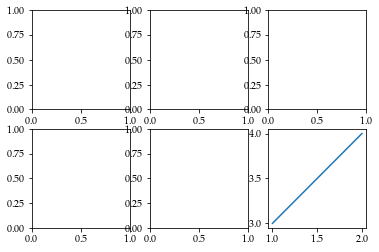

In [4]:
fig, ax = plt.subplots(2,3)
ax[1,2].plot([1,2],[3,4])
fig.show()

NameError: name 'im' is not defined

In [18]:
my_cmap = copy.copy(mpl.cm.get_cmap('cubehelix')) # copy the default cmap
my_cmap.set_bad(my_cmap.colors[0])

AttributeError: 'LinearSegmentedColormap' object has no attribute 'colors'

In [24]:
my_cmap(0)

(0.0, 0.0, 0.0, 1.0)

In [ ]:
['h329','h329','h148','h148','h148','h148']
[33,137,96,127,278,329]


In [ ]:
for sim in ['h329','h242','h229','h148']:
    if sim=='h148':
        snapnums, haloids = snapnums_h148, haloids_h148
    if sim=='h229':
        snapnums, haloids = snapnums_h229, haloids_h229
    if sim=='h242':
        snapnums, haloids = snapnums_h242, haloids_h242
    if sim=='h329':
        snapnums, haloids = snapnums_h329, haloids_h329

    f_base = f'/home/christenc/Data/Sims/{sim}.cosmo50PLK.3072g/{sim}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{sim}.cosmo50PLK.3072gst5HbwK1BH.'
    if sim=='h148':
        f_base = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.'

    lbts = np.array([])
    for i, snapnum in enumerate(snapnums):
        f = f_base + snapnums[i]
        s = pynbody.load(f)
        lbt = age - s.properties['time'].in_units('Gyr')
        lbts = np.append(lbts,lbt)


    print(f'Beginning sim {sim}')
    for haloid in list(np.unique(data[data.sim==sim].haloid)):
        d = data[(data.sim==sim)&(data.haloid==haloid)]
        timesteps = read_timesteps(sim)
        timesteps = timesteps[timesteps.z0haloid==haloid]

        tinfall = d.tinfall.tolist()[0]
        tinfall_lower = d.tinfall_lower.tolist()[0]
        tinfall_upper = d.tinfall_upper.tolist()[0]

        tquench = d.tquench.tolist()[0]
        tquench_lower = d.tquench_lower.tolist()[0]
        tquench_upper = d.tquench_upper.tolist()[0]

        n_star = d.n_star.tolist()[0]
        z0_M_star = d.M_star.tolist()[0]
        is_quenched = np.array(d.quenched,dtype=bool)[0]

        Pram = timesteps.Pram.tolist()[0]
        Prest = timesteps.Prest.tolist()[0]


        i = np.argmin(np.abs(lbts-tinfall)) # infall snapshot index
        f = f_base + snapnums[i] # infall snapshot filepath
        s = pynbody.load(f) # load in the snapshot at infall
        s.physical_units()
        h = s.halos()